# EDA
ラベル統計量の調査

In [1]:
import os
import warnings
import random
from pprint import pprint
import copy
from typing import List, Tuple
import glob
import json
import csv
# import dataclasses
from joblib import Parallel, delayed

import cv2
from tqdm import tqdm
import numpy as np
import pandas as pd
from box import Box
import matplotlib.pyplot as plt
import seaborn as sns

import tifffile
from osgeo import gdal

from sklearn.model_selection import StratifiedKFold, KFold
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:

dfs = []

for phase  in ['train', 'val']:
    PATH_FOLD_CSV = f'../../data/folds/fold0_seed417_{phase}.csv'
    dfs.append(pd.read_csv(PATH_FOLD_CSV))

df = pd.concat(dfs).reindex()
df.head(4)    

,preimg,postimg,flood,building,road,roadspeed,fold
0,../../data/Germany_Training_Public/PRE-event/1...,../../data/Germany_Training_Public/POST-event/...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,4
1,../../data/Germany_Training_Public/PRE-event/1...,../../data/Germany_Training_Public/POST-event/...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,4
2,../../data/Germany_Training_Public/PRE-event/1...,../../data/Germany_Training_Public/POST-event/...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,1
3,../../data/Germany_Training_Public/PRE-event/1...,../../data/Germany_Training_Public/POST-event/...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,3


In [27]:
is_build = []
is_road = [] 
is_speed = []
is_flood = []
flood_build = []
flood_road = []
areas = []

for idx, row in df.iterrows():
    
    # print(row)
    if 'Germany' in row['preimg']:
        area = 'Germany'
    else:
        area = 'Louisiana'
    areas.append(area)    
        
    
    
    ds = gdal.Open(row['building'])
    image = ds.ReadAsArray()
    ds = None
    r = np.count_nonzero(image > 0.5) / image.size
    is_build.append(r)
    
    ds = gdal.Open(row['road'])
    image = ds.ReadAsArray()
    ds = None
    r = np.count_nonzero(image > 0.5) / image.size
    is_road.append(r)
    
    ds = gdal.Open(row['flood'])
    image = ds.ReadAsArray()
    ds = None
    b_r = np.count_nonzero(image[1] > 0.5) / image.size
    r_r = np.count_nonzero(image[3] > 0.5) / image.size
    r = b_r + r_r
    is_flood.append(r)
    flood_build.append(b_r)
    flood_road.append(r_r)


In [28]:
df['r_building'] = is_build
df['r_road'] = is_road
df['r_flood'] = is_flood
df['r_build_flood'] = flood_build
df['r_road_flood'] = flood_road
df['idx'] = df.index
df['area'] = areas
display(df.head())

df['is_building'] = (df['r_building'] != 0.) * 1
df['is_road'] = (df['r_road'] != 1e-6) * 1
df['is_flood'] = (df['r_flood'] != 0.) * 1
df['is_build_flood'] = (df['r_build_flood'] != 0.) * 1
df['is_road_flood'] = (df['r_road_flood'] != 0.) * 1
display(df.head())

,preimg,postimg,flood,building,road,roadspeed,fold,r_building,r_road,r_flood,r_build_flood,r_road_flood,idx,is_building,is_road,is_flood,is_build_flood,is_road_flood,area
0,../../data/Germany_Training_Public/PRE-event/1...,../../data/Germany_Training_Public/POST-event/...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,4,0.014137,0.033238,0.000000,0.000000,0.000000,0,1,1,0,0,0,Germany
1,../../data/Germany_Training_Public/PRE-event/1...,../../data/Germany_Training_Public/POST-event/...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,4,0.000000,0.001449,0.000362,0.000000,0.000362,1,0,1,1,0,1,Germany
2,../../data/Germany_Training_Public/PRE-event/1...,../../data/Germany_Training_Public/POST-event/...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,1,0.024049,0.035080,0.013545,0.005890,0.007656,2,1,1,1,1,1,Germany
3,../../data/Germany_Training_Public/PRE-event/1...,../../data/Germany_Training_Public/POST-event/...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,3,0.028947,0.051440,0.000000,0.000000,0.000000,3,1,1,0,0,0,Germany
4,../../data/Germany_Training_Public/PRE-event/1...,../../data/Germany_Training_Public/POST-event/...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,4,0.010217,0.027076,0.007341,0.002554,0.004787,4,1,1,1,1,1,Germany


,preimg,postimg,flood,building,road,roadspeed,fold,r_building,r_road,r_flood,r_build_flood,r_road_flood,idx,is_building,is_road,is_flood,is_build_flood,is_road_flood,area
0,../../data/Germany_Training_Public/PRE-event/1...,../../data/Germany_Training_Public/POST-event/...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,4,0.014137,0.033238,0.000000,0.000000,0.000000,0,1,1,0,0,0,Germany
1,../../data/Germany_Training_Public/PRE-event/1...,../../data/Germany_Training_Public/POST-event/...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,4,0.000000,0.001449,0.000362,0.000000,0.000362,1,0,1,1,0,1,Germany
2,../../data/Germany_Training_Public/PRE-event/1...,../../data/Germany_Training_Public/POST-event/...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,1,0.024049,0.035080,0.013545,0.005890,0.007656,2,1,1,1,1,1,Germany
3,../../data/Germany_Training_Public/PRE-event/1...,../../data/Germany_Training_Public/POST-event/...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,3,0.028947,0.051440,0.000000,0.000000,0.000000,3,1,1,0,0,0,Germany
4,../../data/Germany_Training_Public/PRE-event/1...,../../data/Germany_Training_Public/POST-event/...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,../../data/Germany_Training_Public/annotations...,4,0.010217,0.027076,0.007341,0.002554,0.004787,4,1,1,1,1,1,Germany


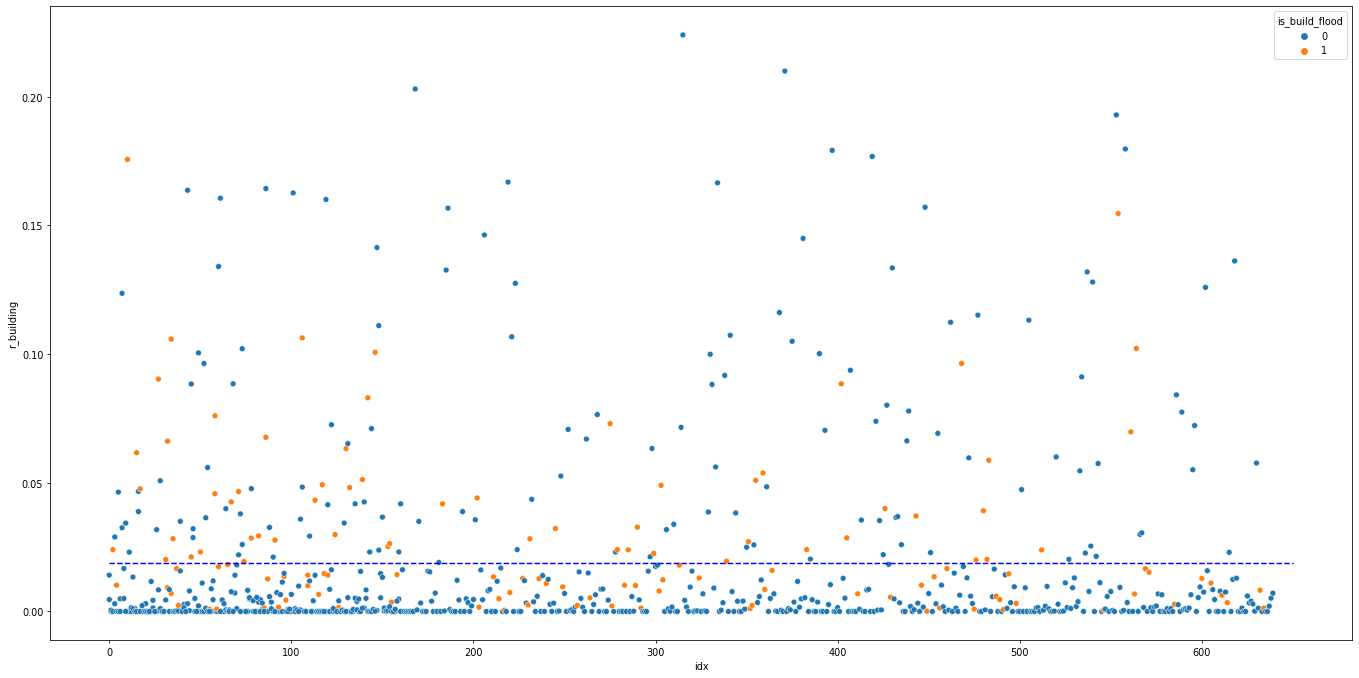

In [20]:
plt.figure(figsize=(24 , 12), dpi=70)
# plt.title('building ratio')
sns.scatterplot(x="idx", y="r_building", hue="is_build_flood", data=df)
plt.hlines(df['r_building'].mean(), 0, 650, "blue", linestyles='dashed')  
plt.show();

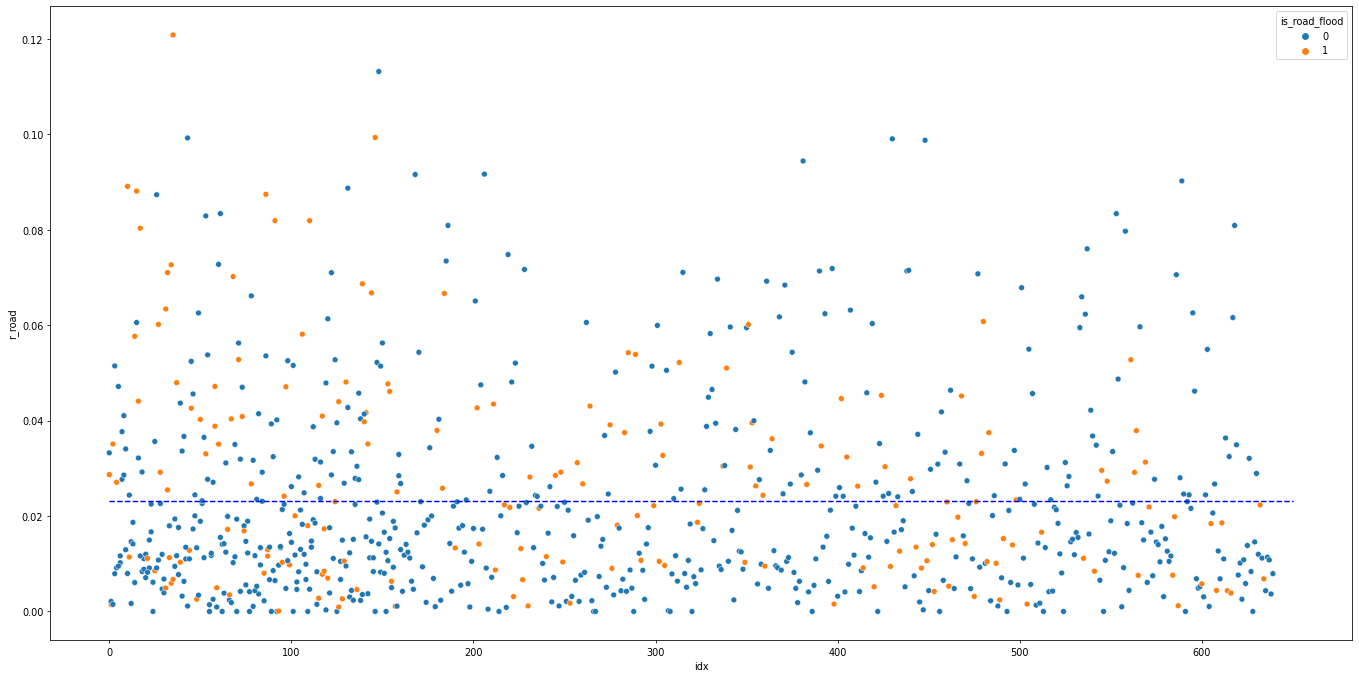

In [21]:
plt.figure(figsize=(24 , 12), dpi=70)
# plt.title('building ratio')
sns.scatterplot(x="idx", y="r_road", hue="is_road_flood", data=df)
plt.hlines(df['r_road'].mean(), 0, 650, "blue", linestyles='dashed')   
plt.show();

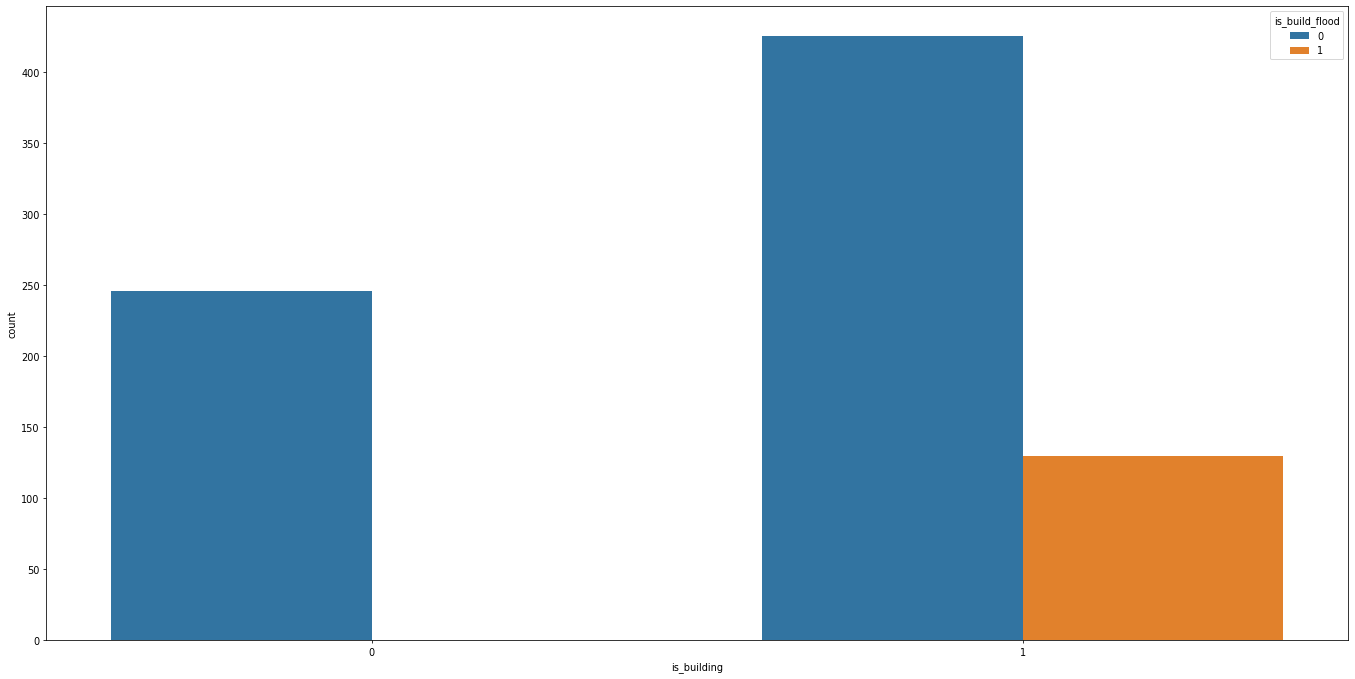

In [25]:
plt.figure(figsize=(24 , 12), dpi=70)
# plt.title('building ratio')
sns.countplot(x="is_building", hue="is_build_flood", data=df)
plt.show();

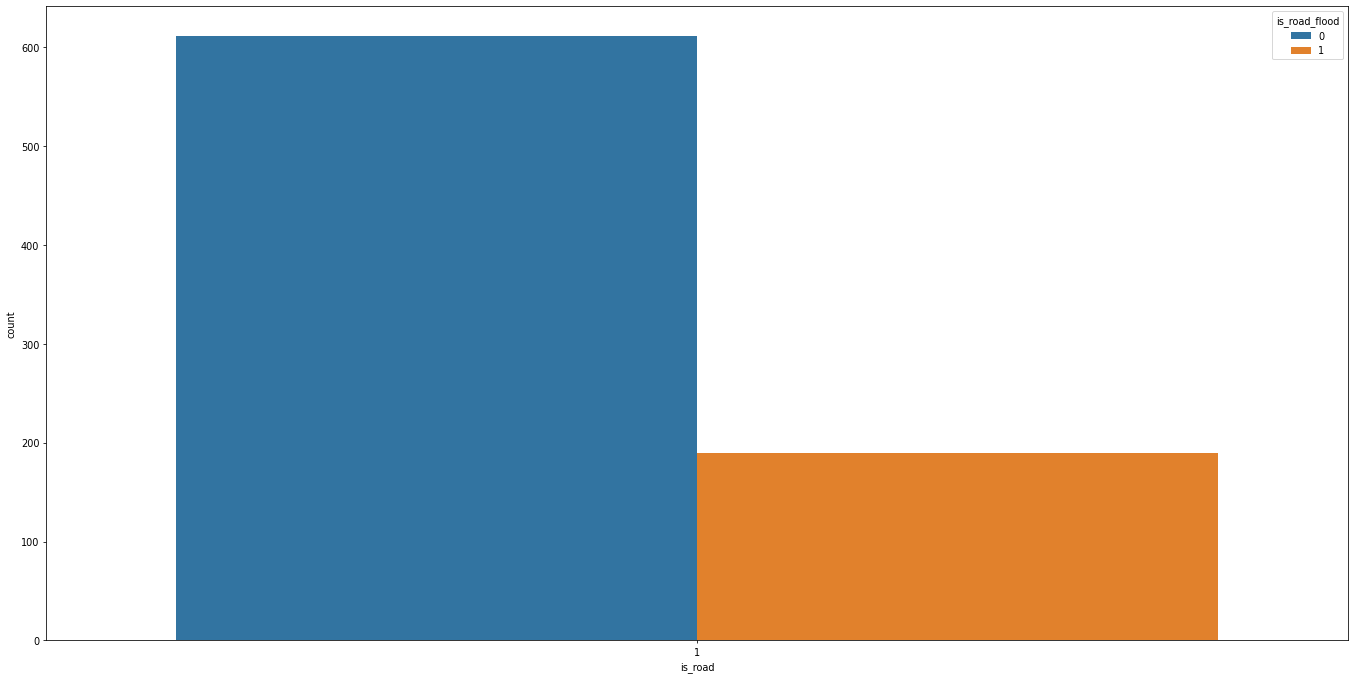

In [26]:
plt.figure(figsize=(24 , 12), dpi=70)
sns.countplot(x="is_road", hue="is_road_flood", data=df)
plt.show();

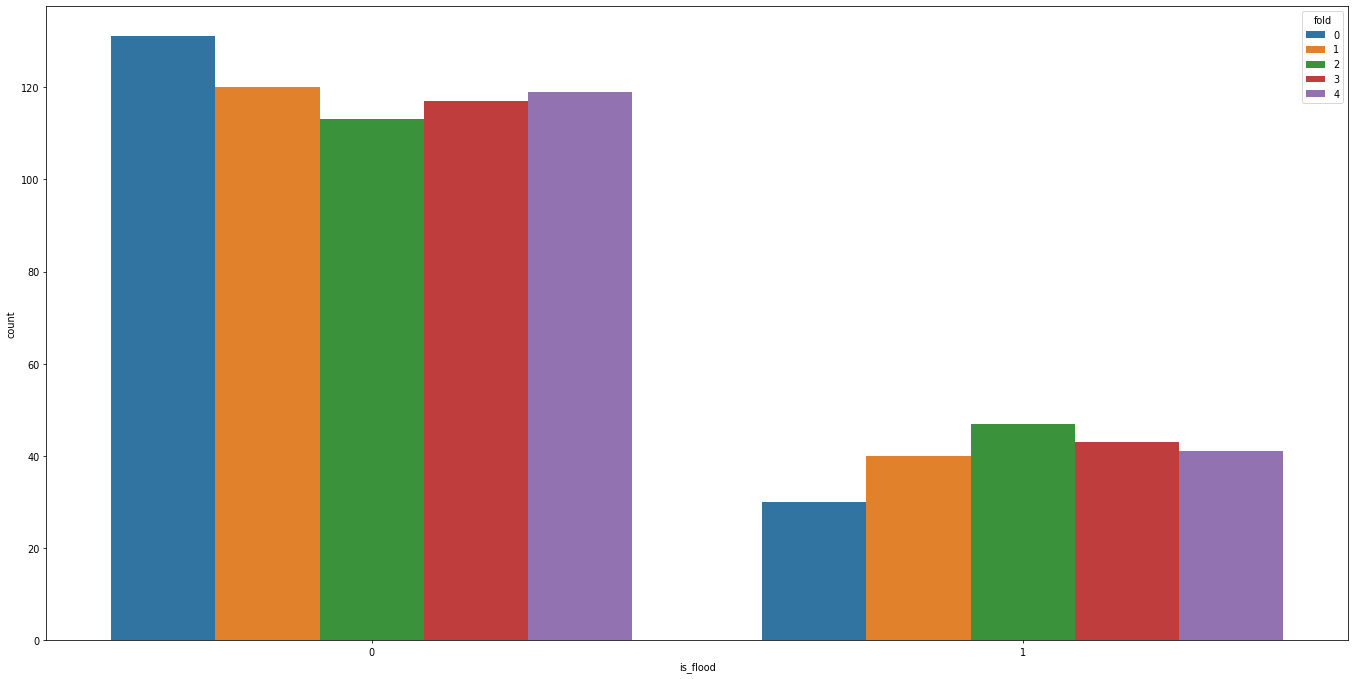

In [24]:
plt.figure(figsize=(24 , 12), dpi=70)
sns.countplot(x="is_flood", hue="fold", data=df)
plt.show();

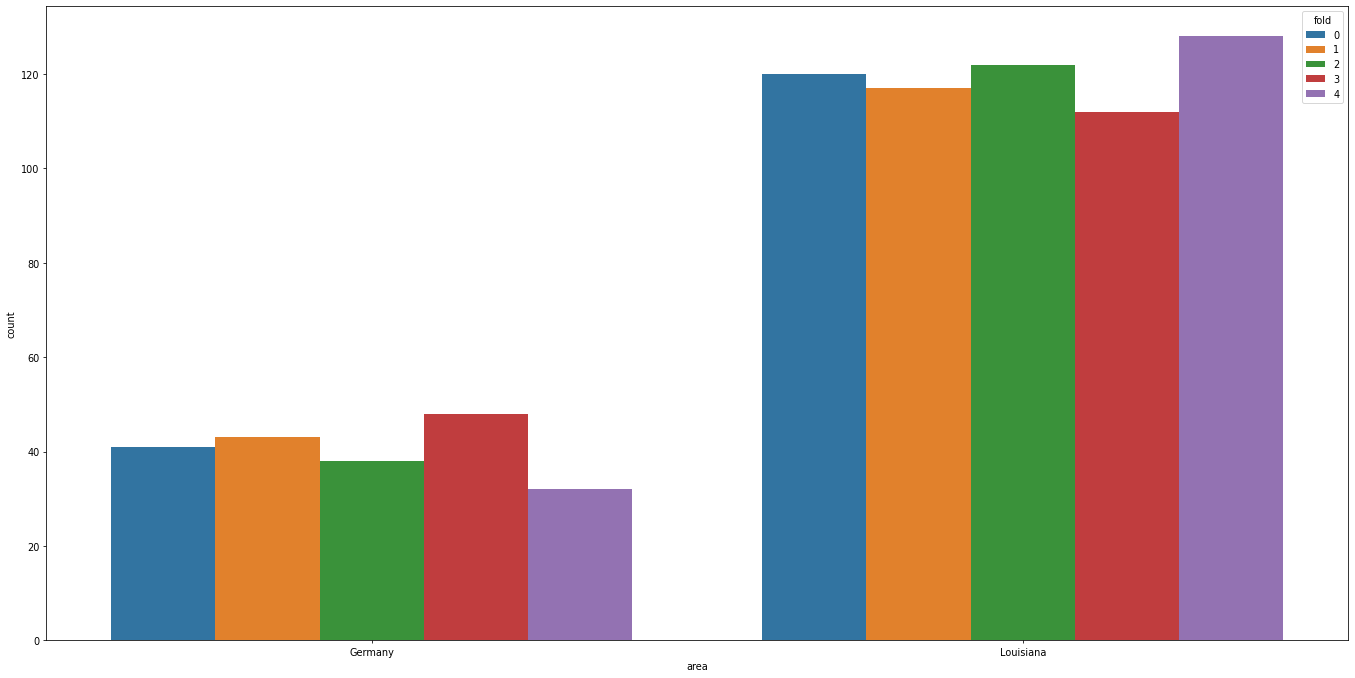

In [29]:
plt.figure(figsize=(24 , 12), dpi=70)
sns.countplot(x="area", hue="fold", data=df)
plt.show();

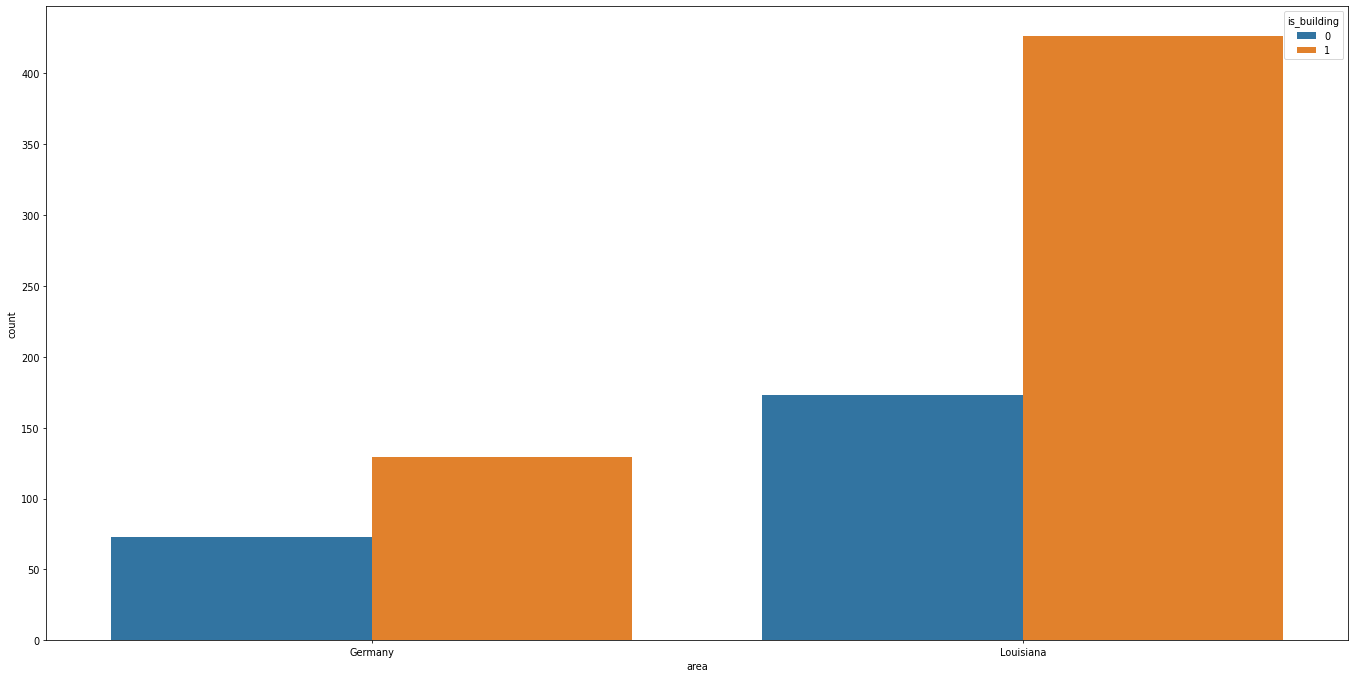

In [30]:
plt.figure(figsize=(24 , 12), dpi=70)
sns.countplot(x="area", hue="is_building", data=df)
plt.show();

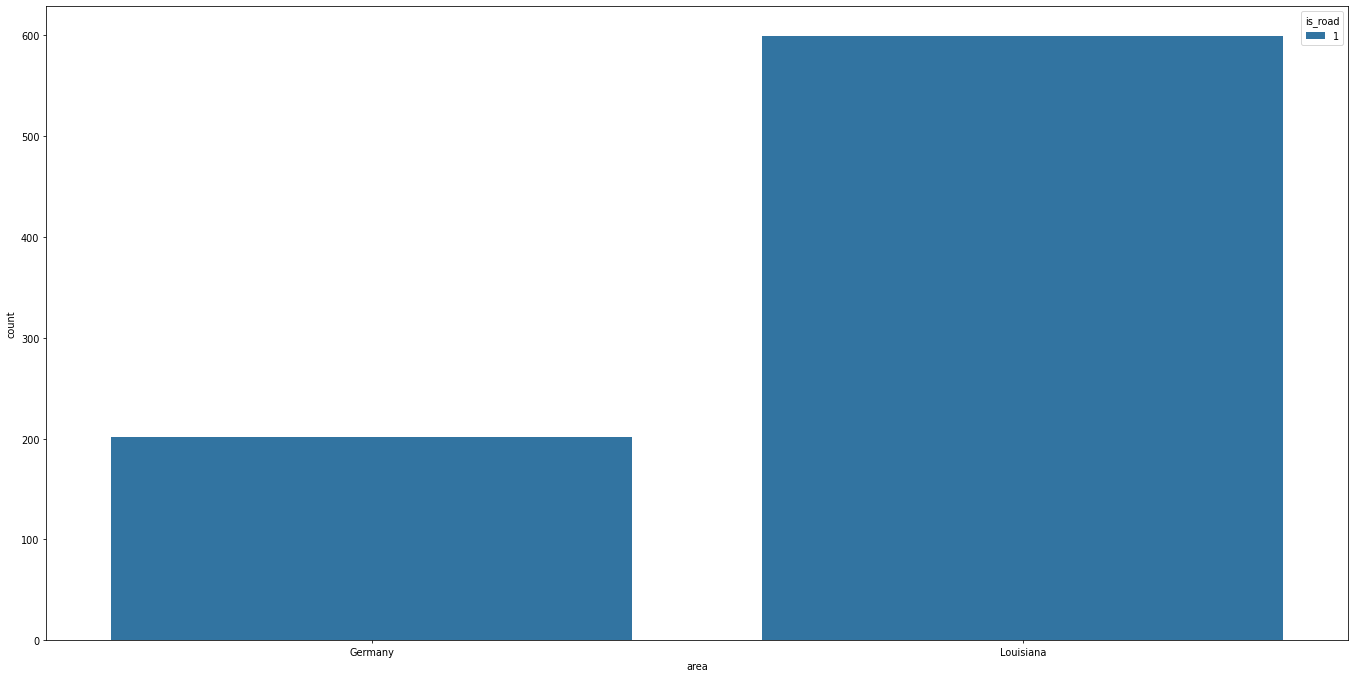

In [31]:
plt.figure(figsize=(24 , 12), dpi=70)
sns.countplot(x="area", hue="is_road", data=df)
plt.show();

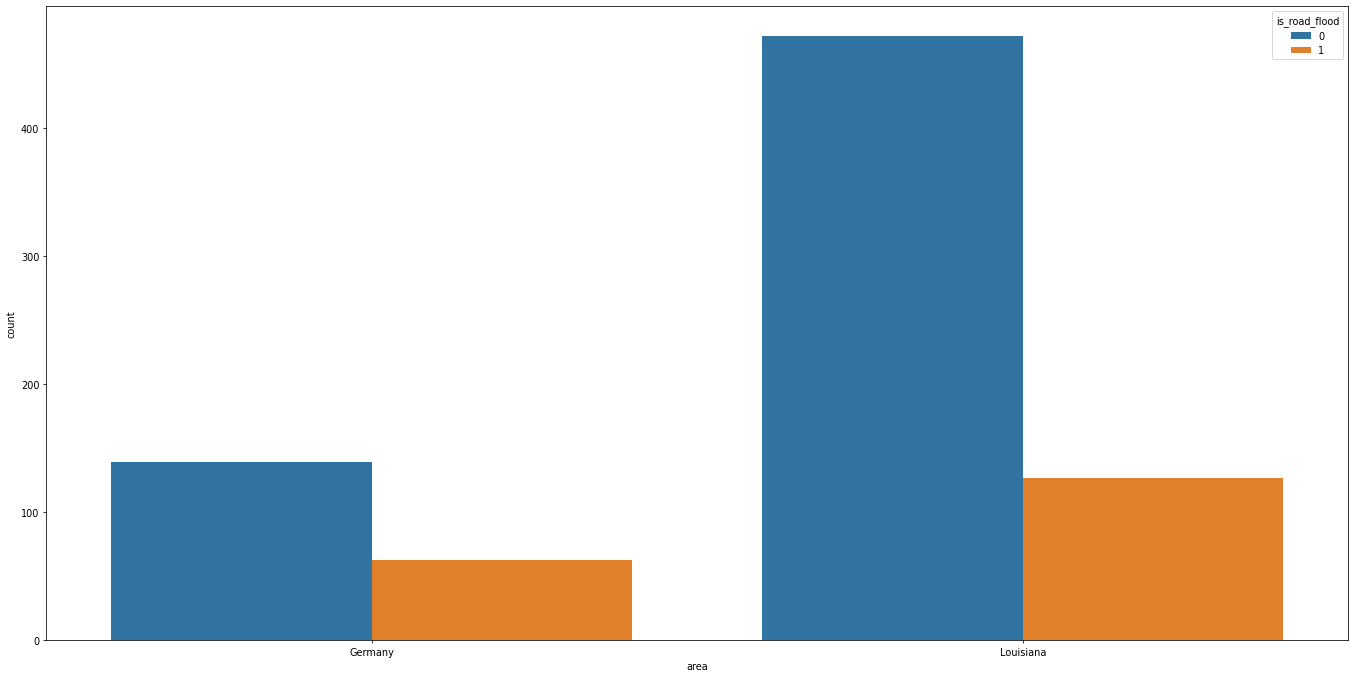

In [32]:
plt.figure(figsize=(24 , 12), dpi=70)
sns.countplot(x="area", hue="is_road_flood", data=df)
plt.show();

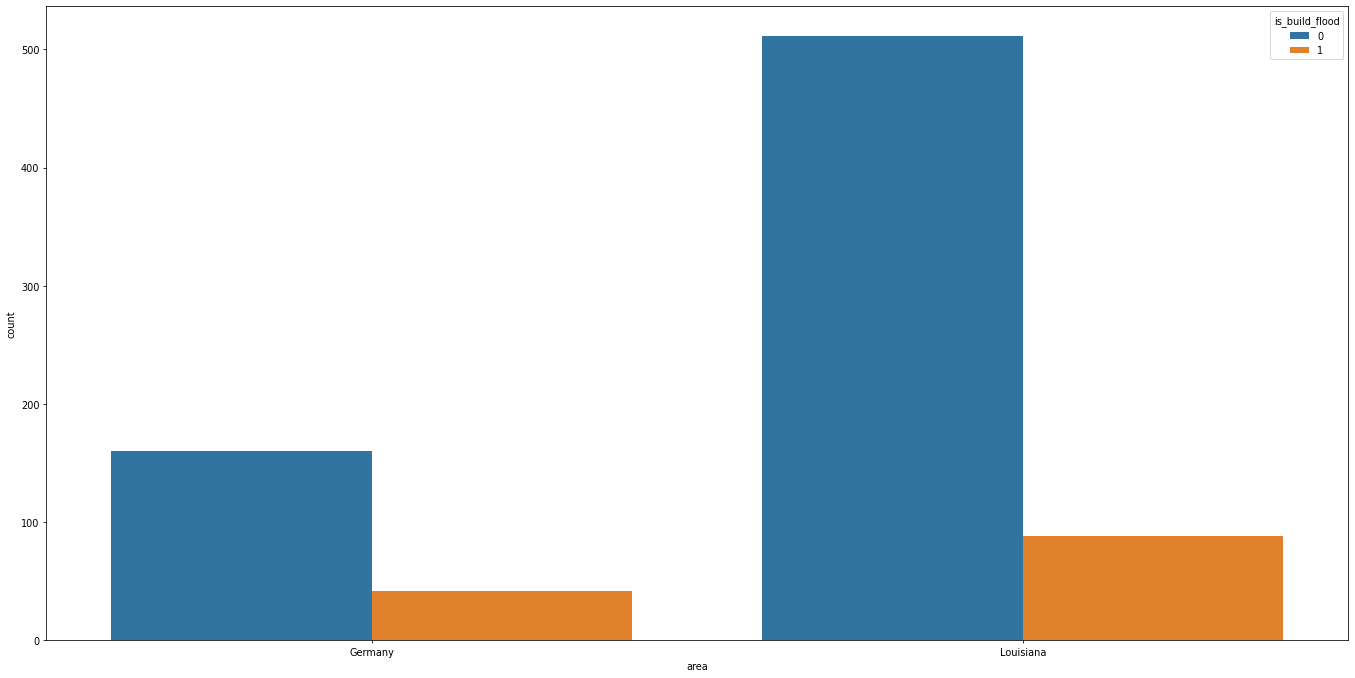

In [33]:
plt.figure(figsize=(24 , 12), dpi=70)
sns.countplot(x="area", hue="is_build_flood", data=df)
plt.show();

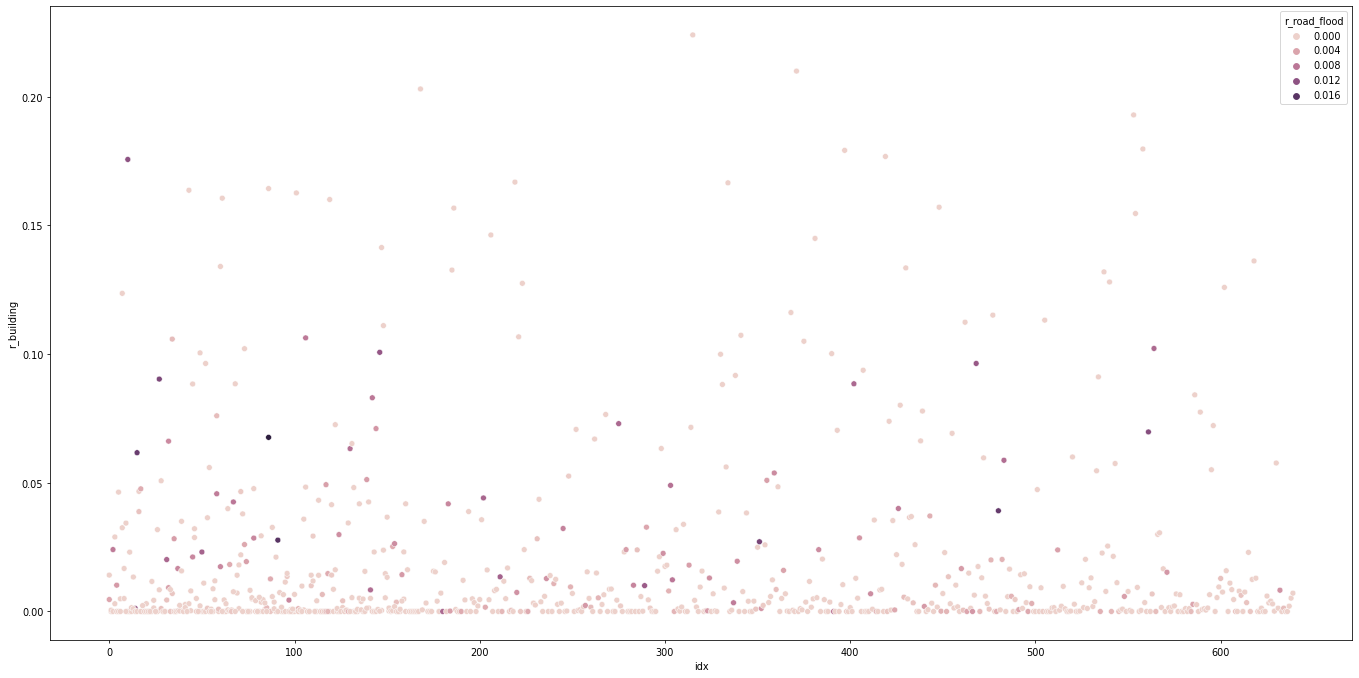

In [41]:
plt.figure(figsize=(24 , 12), dpi=70)
sns.scatterplot(x='idx', y="r_building", hue="r_road_flood", data=df)
plt.show();

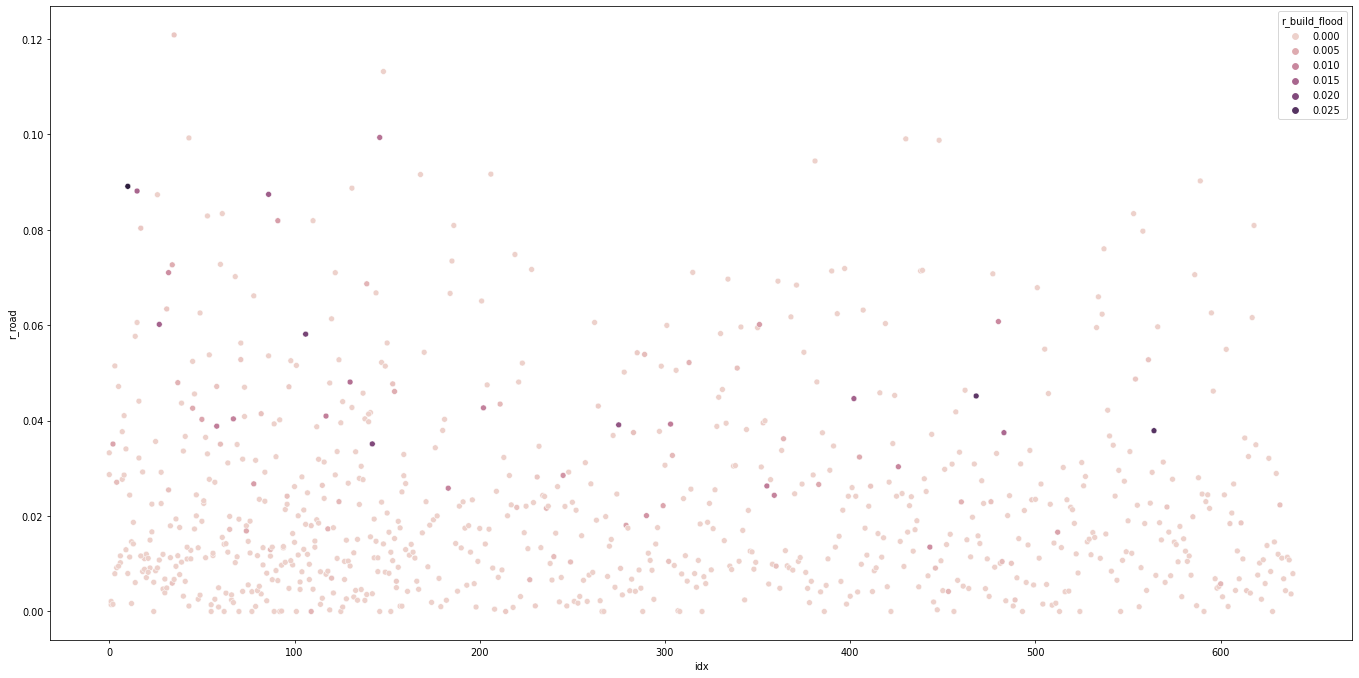

In [40]:
plt.figure(figsize=(24 , 12), dpi=70)
sns.scatterplot(x='idx', y="r_road", hue="r_build_flood", data=df)
plt.show();

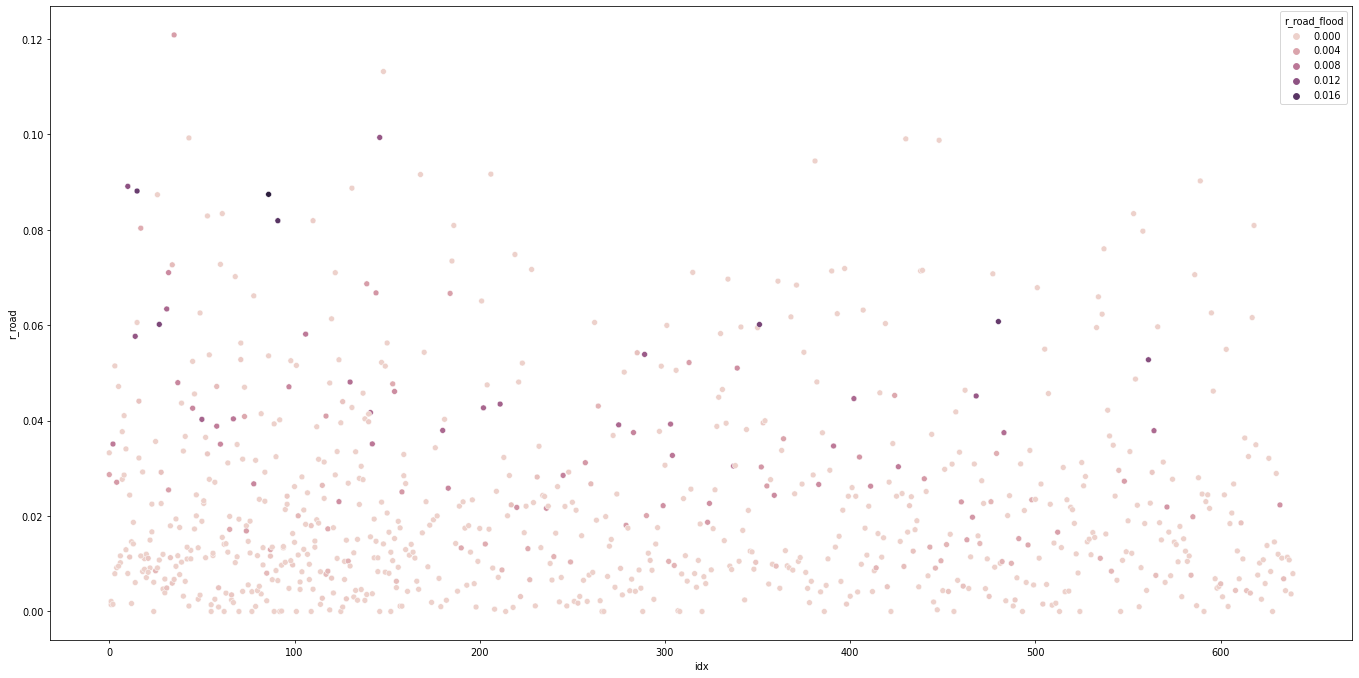

In [42]:
plt.figure(figsize=(24 , 12), dpi=70)
sns.scatterplot(x='idx', y="r_road", hue="r_road_flood", data=df)
plt.show();

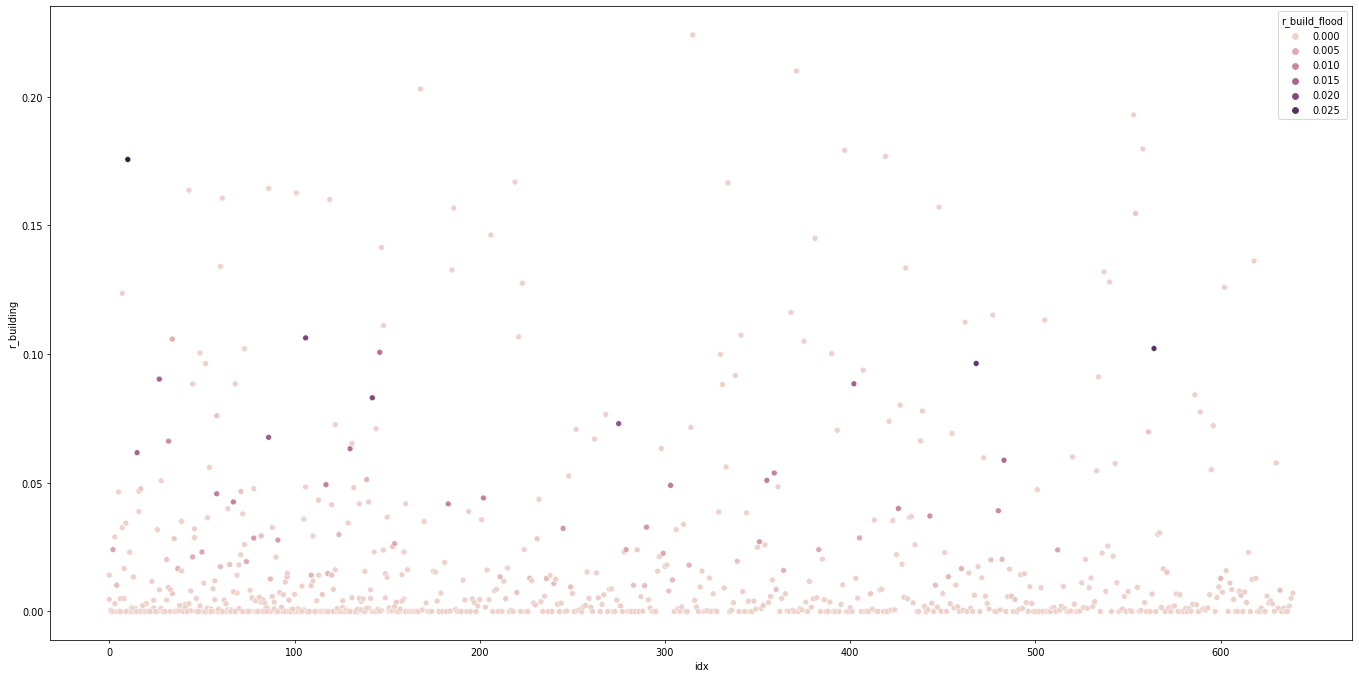

In [43]:
plt.figure(figsize=(24 , 12), dpi=70)
sns.scatterplot(x='idx', y="r_building", hue="r_build_flood", data=df)
plt.show();

## まとめ

- `building` なしが存在
- `raod` なしは存在しない
- 地域差はある
    - `Lousiana` の方がデータが多い
    - `Germany` の方が洪水の割合は多い
- 
